## Importing Required Packages

In [32]:
# crypto_liquidity_analysis_with_gridsearch.py

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
# Match all CSV files in the folder
file_list = glob.glob('/content/drive/MyDrive/pwskills-DataScience_and_AI/Machine Learning Project - CryptoCurrency Liquidity/data/*.csv')

# Read and concatenate all CSV files
df = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)

In [34]:
print("Dataset shape:", df.shape)
print(df.dtypes)
print(df.head())

Dataset shape: (1000, 9)
coin           object
symbol         object
price         float64
1h            float64
24h           float64
7d            float64
24h_volume    float64
mkt_cap       float64
date           object
dtype: object
       coin symbol         price     1h    24h     7d    24h_volume  \
0   Bitcoin    BTC  40851.380000  0.001  0.000 -0.027  2.047612e+10   
1  Ethereum    ETH   2824.420000  0.004  0.029  0.034  1.364041e+10   
2    Tether   USDT      1.000000 -0.000  0.000  0.000  4.413140e+10   
3       BNB    BNB    389.610000  0.002  0.016 -0.010  1.425354e+09   
4  USD Coin   USDC      0.999739 -0.001  0.000 -0.000  3.569816e+09   

        mkt_cap        date  
0  7.760774e+11  2022-03-17  
1  3.390772e+11  2022-03-17  
2  8.020588e+10  2022-03-17  
3  6.556116e+10  2022-03-17  
4  5.259607e+10  2022-03-17  


In [35]:
# ------------------------------------------------------------------------------
# 2. BASIC CLEANING
# ------------------------------------------------------------------------------
# 2.1 Drop any fully empty rows (if present)
df.dropna(how='all', inplace=True)

# 2.2 Convert percent‑change columns from strings to floats
#     e.g., '1h', '24h', '7d' might be like '–2.34%' or '5.12%'
for col in ['1h', '24h', '7d']:
    df[col] = (
        df[col]
          .astype(str)
          .str.replace('%', '')      # remove percent sign
          .str.replace('—', '')      # some data use '—' for missing
          .replace('', np.nan)       # convert empty to NaN
          .astype(float)             # cast to float
    )

# 2.3 Rename columns for Python friendliness
df.rename(columns={
    '1h':     'pct_change_1h',
    '24h':    'pct_change_24h',
    '7d':     'pct_change_7d',
    '24h_volume': 'volume_24h',
    'mkt_cap':     'market_cap'
}, inplace=True)

# Handle missing values: fill with median for numerical columns
df['pct_change_1h'] = df['pct_change_1h'].fillna(df['pct_change_1h'].median())
df['pct_change_24h'] = df['pct_change_24h'].fillna(df['pct_change_24h'].median())
df['pct_change_7d'] = df['pct_change_7d'].fillna(df['pct_change_7d'].median())
df['volume_24h'] = df['volume_24h'].fillna(df['volume_24h'].median())

print("\nAfter cleaning:")
print(df.dtypes)
print(df.isna().sum(), "\n")


After cleaning:
coin               object
symbol             object
price             float64
pct_change_1h     float64
pct_change_24h    float64
pct_change_7d     float64
volume_24h        float64
market_cap        float64
date               object
dtype: object
coin              0
symbol            0
price             0
pct_change_1h     0
pct_change_24h    0
pct_change_7d     0
volume_24h        0
market_cap        0
date              0
dtype: int64 



Top 10 by market cap:
          coin    market_cap
0     Bitcoin  7.760774e+11
500   Bitcoin  7.709915e+11
1    Ethereum  3.390772e+11
501  Ethereum  3.271044e+11
2      Tether  8.020588e+10
502    Tether  7.996516e+10
3         BNB  6.556116e+10
503       BNB  6.404382e+10
4    USD Coin  5.259607e+10
504  USD Coin  5.222214e+10 

Top 10 by 24h volume:
             coin    volume_24h
502       Tether  5.793497e+10
2         Tether  4.413140e+10
500      Bitcoin  3.539076e+10
0        Bitcoin  2.047612e+10
501     Ethereum  1.974870e+10
1       Ethereum  1.364041e+10
511  Binance USD  4.039490e+09
505          XRP  3.925205e+09
504     USD Coin  3.872274e+09
11   Binance USD  3.713595e+09 



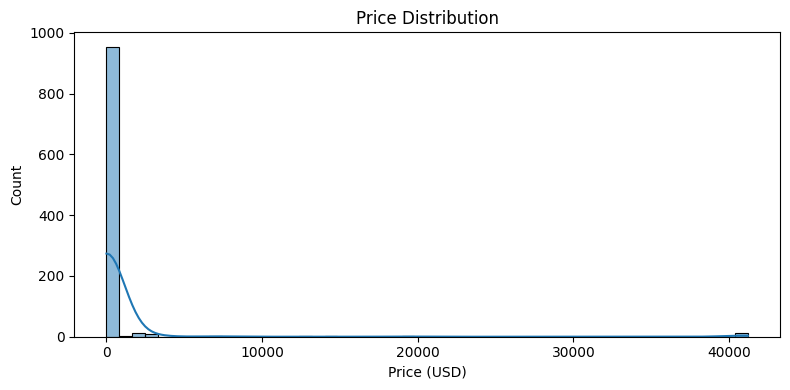

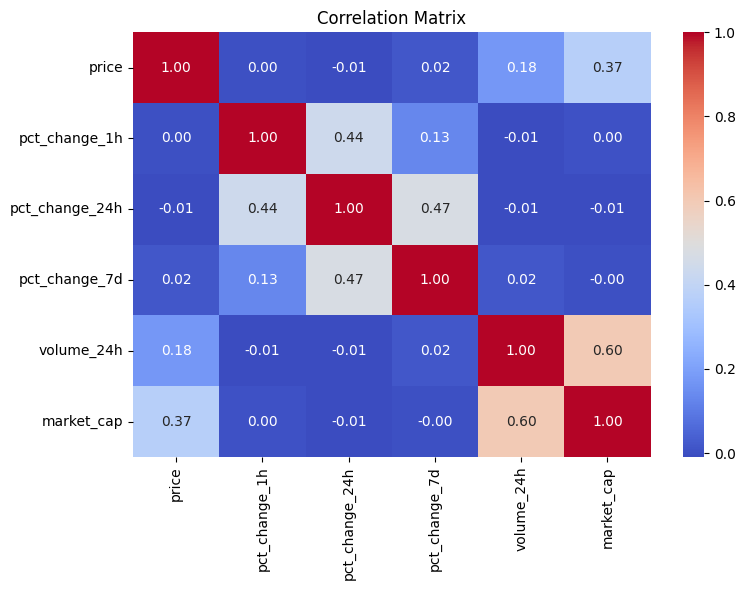

In [36]:
# ------------------------------------------------------------------------------
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------------------------------------------
# 3.1 Top 10 coins by market cap
top10_mcap = df.nlargest(10, 'market_cap')[['coin', 'market_cap']]
print("Top 10 by market cap:\n", top10_mcap, "\n")

# 3.2 Top 10 coins by 24h volume
top10_vol = df.nlargest(10, 'volume_24h')[['coin', 'volume_24h']]
print("Top 10 by 24h volume:\n", top10_vol, "\n")

# 3.3 Distribution of price
plt.figure(figsize=(8, 4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3.4 Correlation heatmap among numeric features
numeric_cols = ['price', 'pct_change_1h', 'pct_change_24h', 'pct_change_7d',
                'volume_24h', 'market_cap']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [37]:
# ------------------------------------------------------------------------------
# 4. FEATURE ENGINEERING
# ------------------------------------------------------------------------------
# Here we only have one snapshot, so we simulate "next-day liquidity" by
# shifting 24h volume to create a 'target' for demonstration.
df.sort_values('market_cap', ascending=False, inplace=True)
df['target_volume_24h'] = df['volume_24h'].shift(-1)
df.dropna(subset=['target_volume_24h'], inplace=True)

# Create ratio features that often signal liquidity:
df['price_to_marketcap'] = df['price'] / df['market_cap']
df['volume_to_marketcap'] = df['volume_24h'] / df['market_cap']
df['volatility_score'] = df['pct_change_7d'].abs()  # absolute 7‑day change as volatility proxy

print("\nFeature-engineered head:\n", df.head(), "\n")


Feature-engineered head:
          coin symbol     price  pct_change_1h  pct_change_24h  pct_change_7d  \
0     Bitcoin    BTC  40851.38          0.001           0.000         -0.027   
500   Bitcoin    BTC  40859.46          0.022           0.030          0.055   
1    Ethereum    ETH   2824.42          0.004           0.029          0.034   
501  Ethereum    ETH   2744.41          0.024           0.034          0.065   
2      Tether   USDT      1.00         -0.000           0.000          0.000   

       volume_24h    market_cap        date  target_volume_24h  \
0    2.047612e+10  7.760774e+11  2022-03-17       3.539076e+10   
500  3.539076e+10  7.709915e+11  2022-03-16       1.364041e+10   
1    1.364041e+10  3.390772e+11  2022-03-17       1.974870e+10   
501  1.974870e+10  3.271044e+11  2022-03-16       4.413140e+10   
2    4.413140e+10  8.020588e+10  2022-03-17       5.793497e+10   

     price_to_marketcap  volume_to_marketcap  volatility_score  
0          5.263828e-08       

In [39]:
# ------------------------------------------------------------------------------
# 5. DEFINE ESTIMATORS & PARAM GRIDS FOR GRID SEARCH
# ------------------------------------------------------------------------------
estimators = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth':    [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators':   [50, 100, 200],
            'learning_rate':  [0.01, 0.1, 0.2],
            'max_depth':      [3, 5, 7]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['rbf', 'linear'],
            'C':      [0.1, 1, 10],
            'gamma':  ['scale', 'auto']
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha':  [0.01, 0.1, 1, 10],
            'solver': ['auto', 'svd']
        }
    }
}

In [40]:
# ------------------------------------------------------------------------------
# 6. GRID SEARCH & COLLECT BEST MODELS
# ------------------------------------------------------------------------------
best_models = {}
for name, cfg in estimators.items():
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(
        estimator  = cfg['model'],
        param_grid = cfg['params'],
        cv         = 3,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = -1
    )
    grid.fit(X_train_scaled, y_train)
    best_models[name] = {
        'estimator':    grid.best_estimator_,
        'best_params':  grid.best_params_,
        'cv_rmse':      np.sqrt(-grid.best_score_)
    }
    print(f"  Best params for {name}: {grid.best_params_}")
    print(f"  CV RMSE: {best_models[name]['cv_rmse']:.3f}\n")

Running GridSearchCV for RandomForest...
  Best params for RandomForest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
  CV RMSE: 2557702499.775

Running GridSearchCV for GradientBoosting...
  Best params for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
  CV RMSE: 2891670682.553

Running GridSearchCV for SVR...
  Best params for SVR: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
  CV RMSE: 3011264202.160

Running GridSearchCV for Ridge...
  Best params for Ridge: {'alpha': 10, 'solver': 'auto'}
  CV RMSE: 3763211234.568



In [41]:
# ------------------------------------------------------------------------------
# 7. EVALUATE TUNED MODELS ON TEST SET
# ------------------------------------------------------------------------------
print("Test-set performance:")
for name, info in best_models.items():
    model = info['estimator']
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"  {name:17s} RMSE = {rmse:.3f}")

Test-set performance:
  RandomForest      RMSE = 272978146.834
  GradientBoosting  RMSE = 321431235.608
  SVR               RMSE = 323716662.771
  Ridge             RMSE = 399730419.936


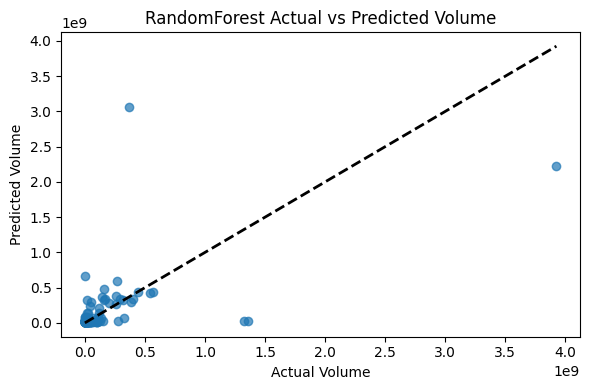

In [42]:
# ------------------------------------------------------------------------------
# 8. VISUALIZE BEST MODEL RESULTS
# ------------------------------------------------------------------------------
# Identify best-performing model
best_name = min(best_models, key=lambda n:
                np.sqrt(mean_squared_error(y_test,
                                           best_models[n]['estimator'].predict(X_test_scaled))))
best_model = best_models[best_name]['estimator']
y_best_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_best_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.title(f"{best_name} Actual vs Predicted Volume")
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.tight_layout()
plt.show()

In [43]:
# ------------------------------------------------------------------------------
# 9. SAVE BEST MODEL & SCALER
# ------------------------------------------------------------------------------
import joblib
joblib.dump(best_model, '/content/drive/MyDrive/pwskills-DataScience_and_AI/Machine Learning Project - CryptoCurrency Liquidity/models/best_crypto_liquidity_model.pkl')
joblib.dump(scaler,    '/content/drive/MyDrive/pwskills-DataScience_and_AI/Machine Learning Project - CryptoCurrency Liquidity/models/scaler.pkl')

['/content/drive/MyDrive/pwskills-DataScience_and_AI/Machine Learning Project - CryptoCurrency Liquidity/models/scaler.pkl']